In [1]:
import numpy as np
import numpy.ma as ma
import pickle
import os
from astropy.table import Table, vstack
import multiprocess as mp
import tqdm

from matplotlib import pyplot as plt
import matplotlib as mpl

# Data Loading

In [2]:
pzchat = np.load('../outputs/p_z_chat/BFD.npy')
pzchat_weights = np.load('../outputs/p_z_chat/BFD_weights.npy')

std = np.load('../outputs/p_z_chat/BFD_std.npy')

redshifts = np.load('../outputs/p_z_chat/redshifts.npy')

with open('../outputs/mock_assignments/simulations.pkl', 'rb') as f:
    sims = pickle.load(f)

dp = np.array(sims['deep position'])
wp = np.array(sims['wide positions'])
wf = np.array(sims['wide fluxes'])
we = np.array(sims['wide errors'])
z = np.array(sims['z'])
ids = np.array(sims['id'])

wideres = 32

/var/folders/nt/7hp8jjq563b09vy01vqx17dh0000gn/T/ipykernel_31339/1471554101.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  wp = np.array(sims['wide positions'])
/var/folders/nt/7hp8jjq563b09vy01vqx17dh0000gn/T/ipykernel_31339/1471554101.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  wf = np.array(sims['wide fluxes'])
/var/folders/nt/7hp8jjq563b09vy01vqx17dh0000gn/T/ipykernel_31339/1471554101.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with diff

In [3]:
ng = np.sum([len(w) for w in wp])
print(ng, "galaxies to process")

9122658 galaxies to process


## Initial Trash Bin Cut and Processing
First, we will remove wide cells with large standard deviations, putting them into a separate bin (the trash bin). 

In [4]:
trash_bins = np.where(std > 1.0)[0]

In [5]:
num_inds = 1000
inds = np.array_split(np.arange(len(z)),num_inds)

In [6]:
def make_table(i):
    all_z = np.array([]) ; all_wc = np.array([]) 
    all_dc = np.array([]) ; all_id = np.array([]) 
    all_wf = np.zeros((0,4)) ; all_we = np.zeros((0,4))
    
    rej_z = np.array([]) ; rej_wc = np.array([])
    rej_dc = np.array([]) ; rej_id = np.array([]) 
    rej_wf = np.zeros((0,4)) ; rej_we = np.zeros((0,4))
    
    idcs = inds[i]
    for bfd_id, zz, wcell, dcell, wflux, werr in zip(ids[idcs], z[idcs], wp[idcs], 
                                                     dp[idcs], wf[idcs], we[idcs]):

        if len(wcell)==0: continue
        acc_mask = np.array([(c not in trash_bins) for c in wcell])
        
        num_accepted = len(np.where(acc_mask)[0])
        all_id = np.append(all_id, [bfd_id]*num_accepted)
        all_z = np.append(all_z, [zz]*num_accepted)
        all_dc = np.append(all_dc, [dcell]*num_accepted)
        all_wc = np.append(all_wc, np.array(wcell)[acc_mask])
        all_wf = np.append(all_wf, np.array(wflux)[acc_mask], axis=0)
        all_we = np.append(all_we, np.array(werr)[acc_mask], axis=0)
                          
        rej_mask = ~acc_mask
        num_rejected = len(np.where(rej_mask)[0])
        rej_id = np.append(rej_id, [bfd_id]*num_rejected)
        rej_z = np.append(rej_z, [zz]*num_rejected)
        rej_dc = np.append(rej_dc, [dcell]*num_rejected)
        rej_wc = np.append(rej_wc, np.array(wcell)[rej_mask])
        rej_wf = np.append(rej_wf, np.array(wflux)[rej_mask], axis=0)
        rej_we = np.append(rej_we, np.array(werr)[rej_mask], axis=0)
        
    t = Table([all_id, all_z, all_wc, all_dc, all_wf, all_we], names=['original_id', 'Z', 'WC', 'DC', 'WF', 'WE'])
    t_rej = Table([rej_id, rej_z, rej_wc, rej_dc, rej_wf, rej_we], names=['original_id', 'Z', 'WC', 'DC', 'WF', 'WE'])
    
    return t, t_rej

In [7]:
acc_fname = '../outputs/binned_data/accepted.fits'
rej_fname = '../outputs/binned_data/rejected.fits'
if not os.path.exists(rej_fname):
    
    with mp.Pool(10) as p:
        results = list(tqdm.tqdm(p.imap(make_table, range(num_inds)), total=num_inds))
    
    t = results[0][0]
    t_rej = results[0][1]
    for i,(ti, tri) in enumerate(results[1:]):
        if i%100 == 0: print(i, len(t))
        t = vstack([t,ti])
        t_rej = vstack([t_rej, tri])
    
    t.write(acc_fname, overwrite=True)
    t_rej.write(rej_fname, overwrite=True)
else:
    t = Table.read(acc_fname)
    t_rej = Table.read(rej_fname)
    
print("%.02f percent of galaxies in the trash bin"%((len(t_rej)/(len(t)+len(t_rej)))*100))

10.25 percent of galaxies in the trash bin


In [8]:
gb_wc = t.group_by('WC')
med_ag = gb_wc.groups.aggregate(np.nanmedian)
med = np.zeros((wideres*wideres))
idcs = np.array(med_ag['WC']).astype(int)
med[idcs] = med_ag['Z']

/Users/danecross/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [9]:
med_z = []
for row in t:
    cell = int(row['WC'])
    med_z += [med[cell]]
t.add_column(med_z, name='cell Z')
ordered_by_cell_z = t.group_by('cell Z')

In [10]:
masks = {}

# 4 Bins

In [11]:
nbins = 4
bins = [] ; current_total = 0

for group in ordered_by_cell_z.groups:
    current_total += len(group)
    if current_total//(len(t['Z'])/nbins) > len(bins):
        bins += [group[0]['cell Z']]
        
print(bins)

[0.6721000075340271, 0.9262999892234802, 1.232300043106079, 4.959000110626221]


In [12]:
assigned_bins = np.digitize(t['cell Z'], bins=bins)
trash_masks = [ma.make_mask(t['WC'] == trash_cell) for trash_cell in trash_bins]
trash_mask = ma.make_mask(np.zeros_like(assigned_bins))
for m in trash_masks:
    trash_mask = np.ma.mask_or(trash_mask, m)
assigned_bins[trash_mask] = -1
t['z bin %i'%nbins] = assigned_bins

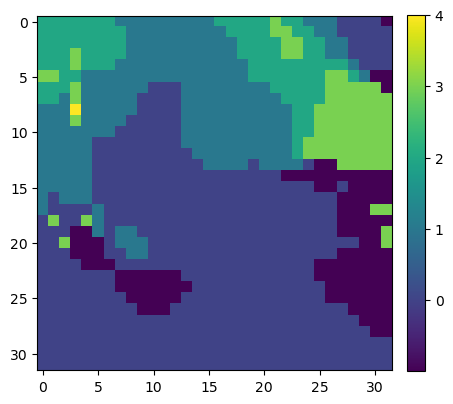

In [13]:
binned_data = np.array(np.digitize(med, bins=bins), dtype=float)
binned_data = np.array([bd if cell not in trash_bins else -1 for cell, bd in zip(range(wideres**2), binned_data)])
plt.imshow(binned_data.reshape((wideres,wideres)))
plt.gcf().set_size_inches(5,5)
plt.colorbar(ticks=[0,1,2,3,4], fraction=0.046, pad=0.04)
plt.show()

In [14]:
with open('../outputs/binned_data/wide_bins_4.pkl', 'wb') as f:
    pickle.dump(binned_data, f)

In [15]:
binned_all_data = [np.where(t['z bin %i'%nbins]==bindex) for bindex in range(nbins)]
masks['4'] = binned_all_data

2043651
2032702
1987962
2122397


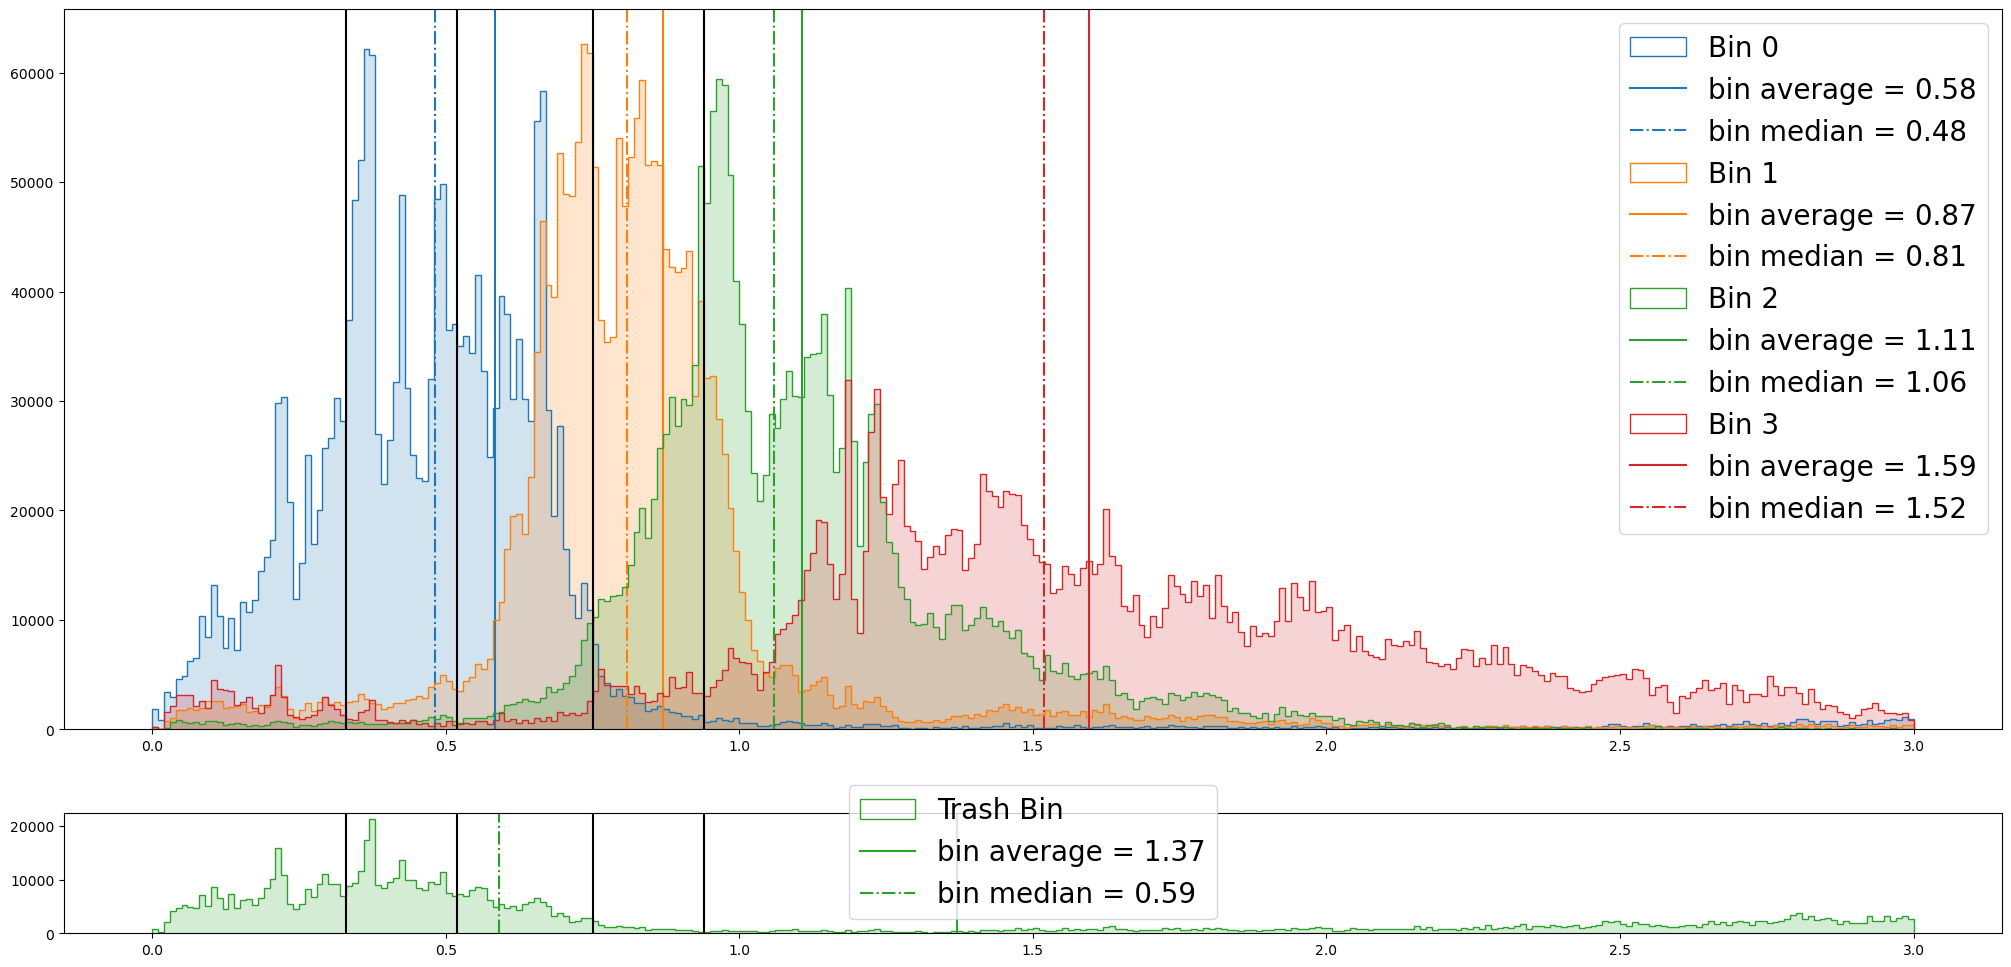

In [16]:
colors = [plt.cm.tab20(i*2) for i in range(5)]

fig, ax = plt.subplots(2, figsize=(25,12), height_ratios=[6,1])
r = (0,3)
for i,mask in enumerate(binned_all_data):
    print(len(t[mask]['Z']))
    ax[0].hist(t[mask]['Z'], 300, range=r,histtype='step', color=colors[i], label="Bin %i"%i)
    ax[0].hist(t[mask]['Z'], 300, range=r, alpha=0.2, color=colors[i])
    
    av = np.average(t[mask]['Z']) ; mm = np.median(t[mask]['Z'])
    ax[0].axvline(av, color=colors[i], label='bin average = %.02f'%av)
    ax[0].axvline(mm, linestyle='-.', color=colors[i], label='bin median = %.02f'%mm)
    

ax[1].hist(t_rej['Z'], 300, range=r, alpha=0.2, color=colors[2])
ax[1].hist(t_rej['Z'], 300, range=r, color=colors[2], histtype='step', label='Trash Bin')
av = np.average(t_rej['Z']) ; mm = np.median(t_rej['Z'])
ax[1].axvline(av, color=colors[2], label='bin average = %.02f'%av)
ax[1].axvline(mm, linestyle='-.', color=colors[2], label='bin median = %.02f'%mm)

y3_means = [0.33, 0.52, 0.75, 0.94]
for a in ax:
    for m in y3_means:
        a.axvline(m, color='black')

ax[0].legend(fontsize=20, loc='upper right')
ax[1].legend(fontsize=20)
plt.show()

2043651
2032702
1987962
2122397


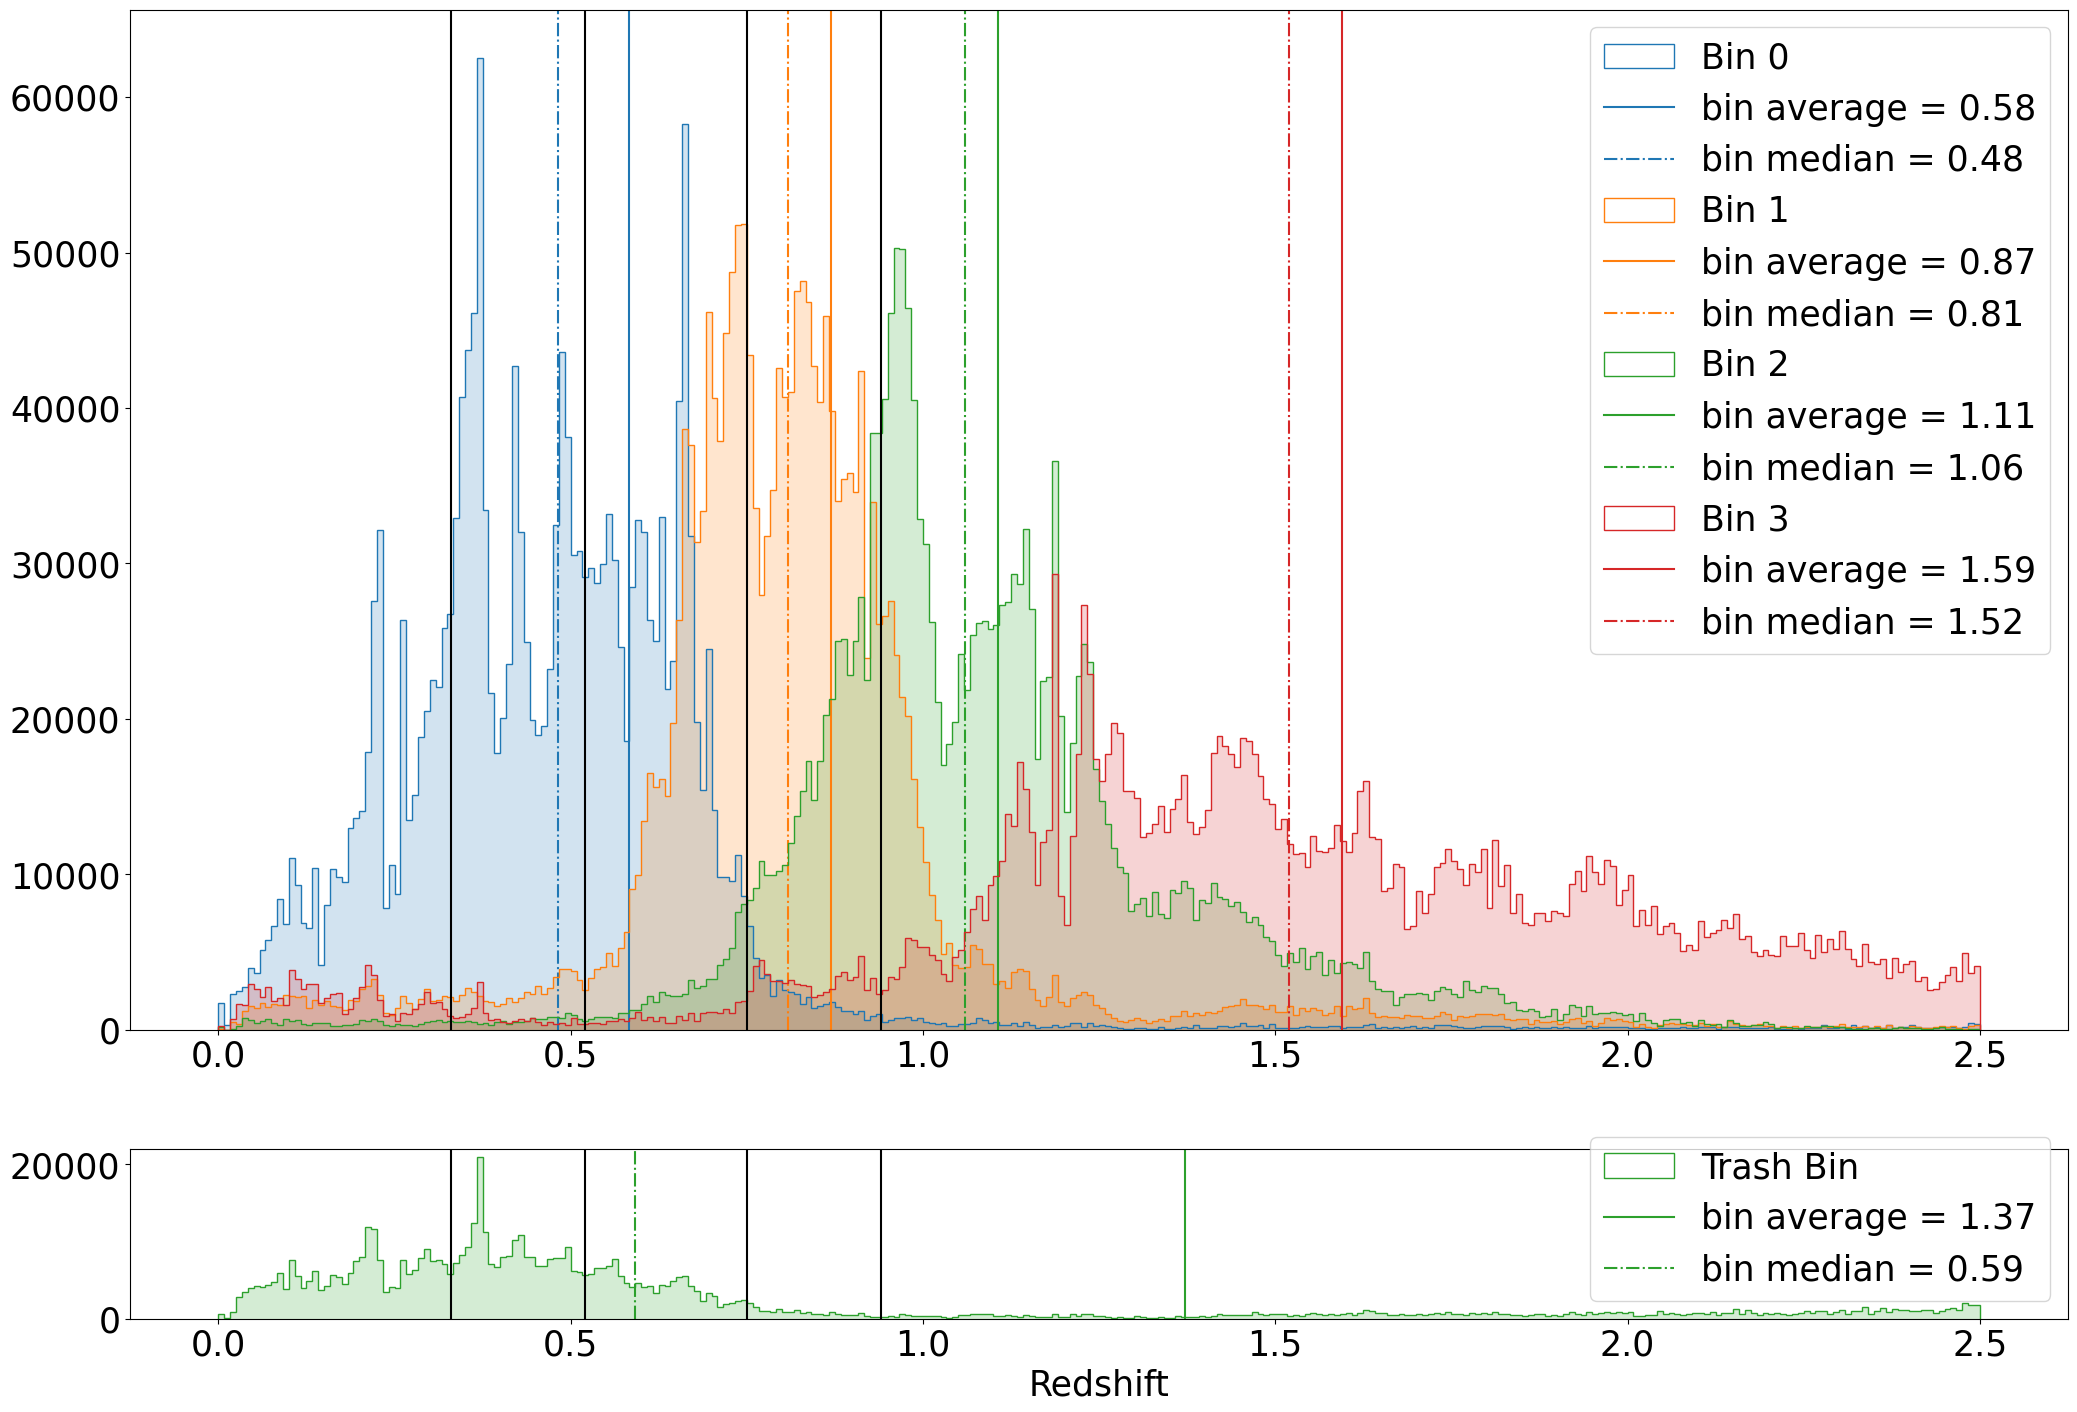

In [17]:
colors = [plt.cm.tab20(i*2) for i in range(5)]

fig, ax = plt.subplots(2, figsize=(25,17), height_ratios=[6,1])
r = (0,2.5)
for i,mask in enumerate(binned_all_data):
    print(len(t[mask]['Z']))
    ax[0].hist(t[mask]['Z'], 300, range=r,histtype='step', color=colors[i], label="Bin %i"%i)
    ax[0].hist(t[mask]['Z'], 300, range=r, alpha=0.2, color=colors[i])
    
    av = np.average(t[mask]['Z']) ; mm = np.median(t[mask]['Z'])
    ax[0].axvline(av, color=colors[i], label='bin average = %.02f'%av)
    ax[0].axvline(mm, linestyle='-.', color=colors[i], label='bin median = %.02f'%mm)
    

ax[1].hist(t_rej['Z'], 300, range=r, alpha=0.2, color=colors[2])
ax[1].hist(t_rej['Z'], 300, range=r, color=colors[2], histtype='step', label='Trash Bin')
av = np.average(t_rej['Z']) ; mm = np.median(t_rej['Z'])
ax[1].axvline(av, color=colors[2], label='bin average = %.02f'%av)
ax[1].axvline(mm, linestyle='-.', color=colors[2], label='bin median = %.02f'%mm)

y3_means = [0.33, 0.52, 0.75, 0.94]
for a in ax:
    for m in y3_means:
        a.axvline(m, color='black')

ax[0].legend(fontsize=25)
ax[1].legend(fontsize=25)
ax[0].tick_params(axis='both', which='major', labelsize=25)
ax[1].tick_params(axis='both', which='major', labelsize=25)

ax[1].set_xlabel('Redshift', fontsize=25)
plt.show()

# 5 Bins

In [18]:
nbins = 5
bins = [] ; current_total = 0

for group in ordered_by_cell_z.groups:
    current_total += len(group)
    if current_total//(len(t['Z'])/nbins) > len(bins):
        bins += [group[0]['cell Z']]
        
print(bins)

[0.6241999864578247, 0.8457000255584717, 1.034600019454956, 1.2868000268936157]


In [19]:
assigned_bins = np.digitize(t['cell Z'], bins=bins)
trash_masks = [ma.make_mask(t['WC'] == trash_cell) for trash_cell in trash_bins]
trash_mask = ma.make_mask(np.zeros_like(assigned_bins))
for m in trash_masks:
    trash_mask = np.ma.mask_or(trash_mask, m)
assigned_bins[trash_mask] = -1
t['z bin %i'%nbins] = assigned_bins

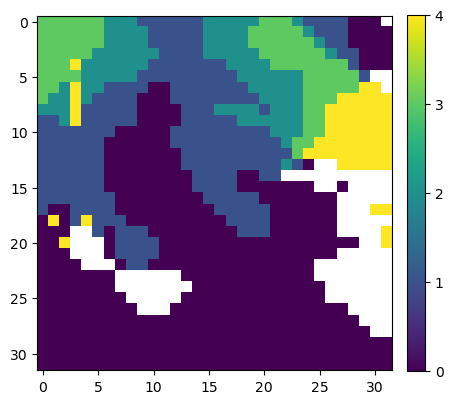

In [20]:
binned_data = np.array(np.digitize(med, bins=bins), dtype=float)
binned_data = np.array([bd if cell not in trash_bins else np.nan for cell, bd in zip(range(wideres**2), binned_data)])
plt.imshow(binned_data.reshape((wideres,wideres)))
plt.gcf().set_size_inches(5,5)
plt.colorbar(ticks=[0,1,2,3,4], fraction=0.046, pad=0.04)
plt.show()

In [21]:
with open('../outputs/binned_data/wide_bins_5.pkl', 'wb') as f:
    pickle.dump(binned_data, f)

In [22]:
binned_all_data = [np.where(t['z bin %i'%nbins]==bindex) for bindex in range(nbins)]
masks['5'] = binned_all_data

1634414
1629930
1633987
1650540
1638448


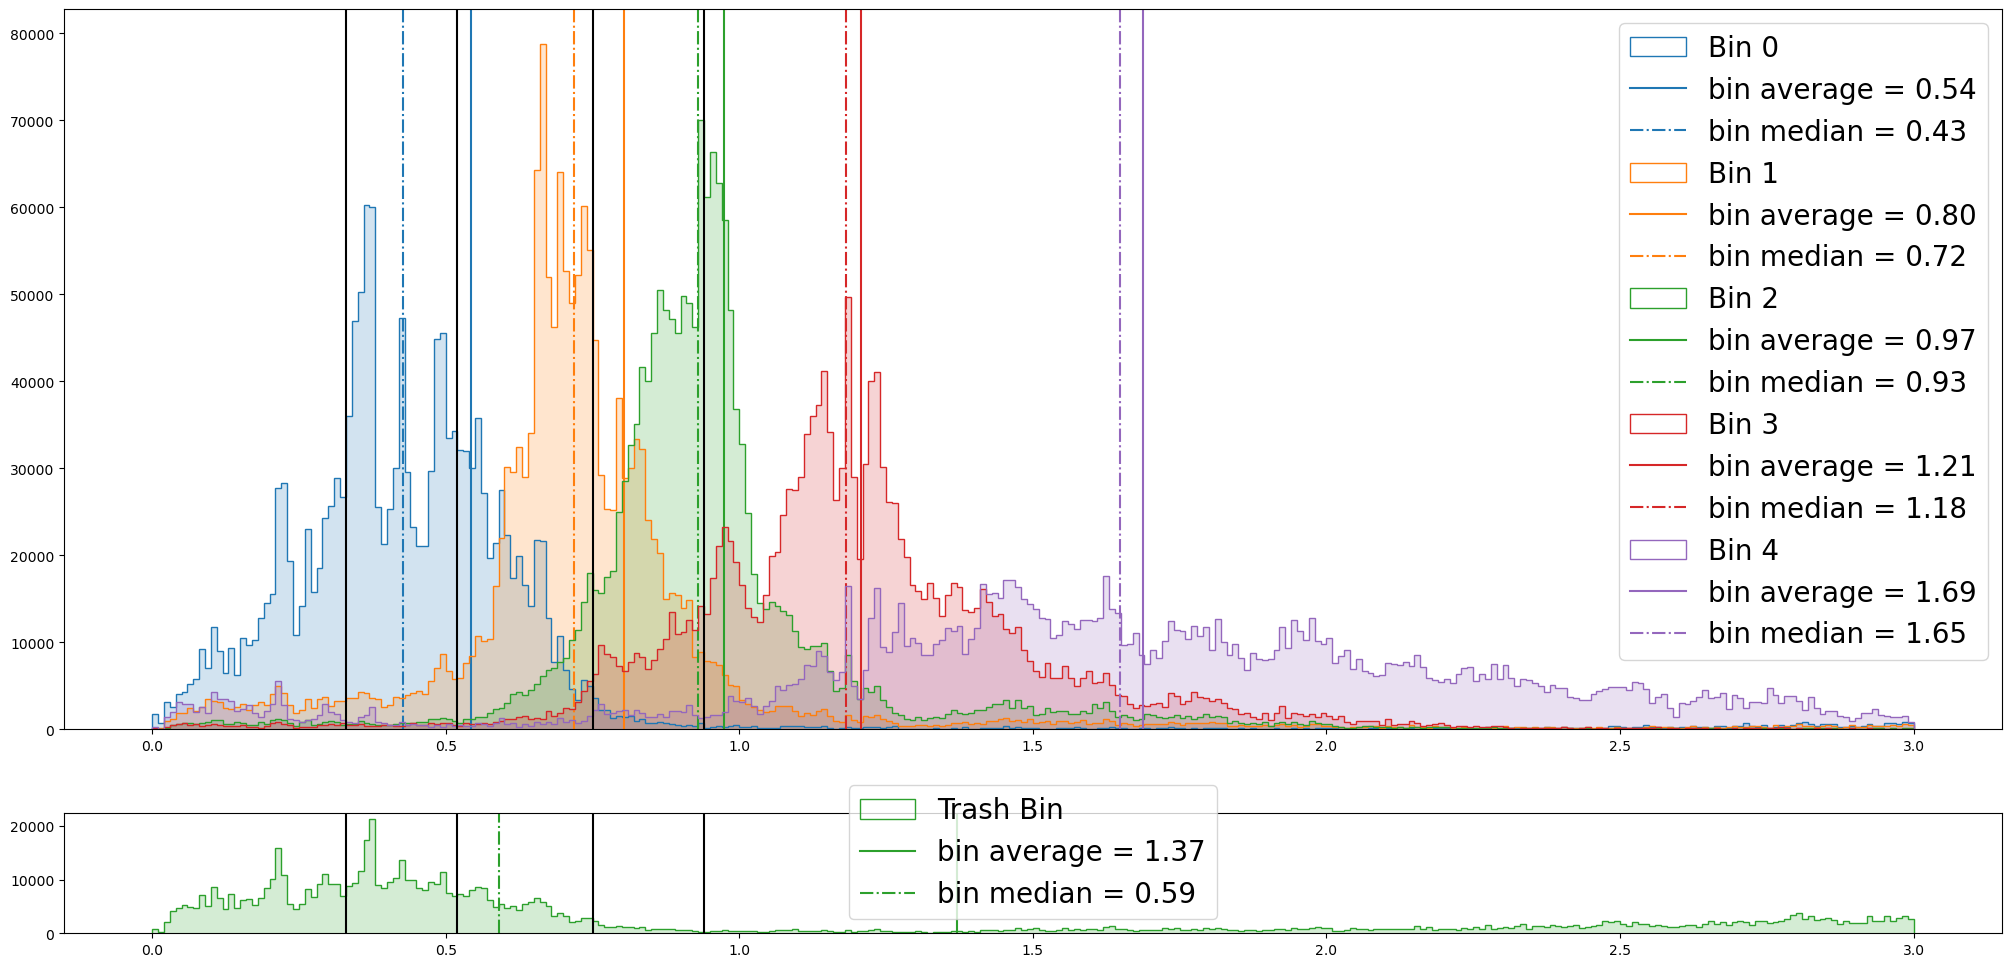

In [23]:
colors = [plt.cm.tab20(i*2) for i in range(5)]

fig, ax = plt.subplots(2, figsize=(25,12), height_ratios=[6,1])
r = (0,3)
for i,mask in enumerate(binned_all_data):
    print(len(t[mask]['Z']))
    ax[0].hist(t[mask]['Z'], 300, range=r,histtype='step', color=colors[i], label="Bin %i"%i)
    ax[0].hist(t[mask]['Z'], 300, range=r, alpha=0.2, color=colors[i])
    
    av = np.average(t[mask]['Z']) ; mm = np.median(t[mask]['Z'])
    ax[0].axvline(av, color=colors[i], label='bin average = %.02f'%av)
    ax[0].axvline(mm, linestyle='-.', color=colors[i], label='bin median = %.02f'%mm)
    

ax[1].hist(t_rej['Z'], 300, range=r, alpha=0.2, color=colors[2])
ax[1].hist(t_rej['Z'], 300, range=r, color=colors[2], histtype='step', label='Trash Bin')
av = np.average(t_rej['Z']) ; mm = np.median(t_rej['Z'])
ax[1].axvline(av, color=colors[2], label='bin average = %.02f'%av)
ax[1].axvline(mm, linestyle='-.', color=colors[2], label='bin median = %.02f'%mm)

y3_means = [0.33, 0.52, 0.75, 0.94]
for a in ax:
    for m in y3_means:
        a.axvline(m, color='black')

ax[0].legend(fontsize=20)
ax[1].legend(fontsize=20)
plt.show()

1634414
1629930
1633987
1650540
1638448


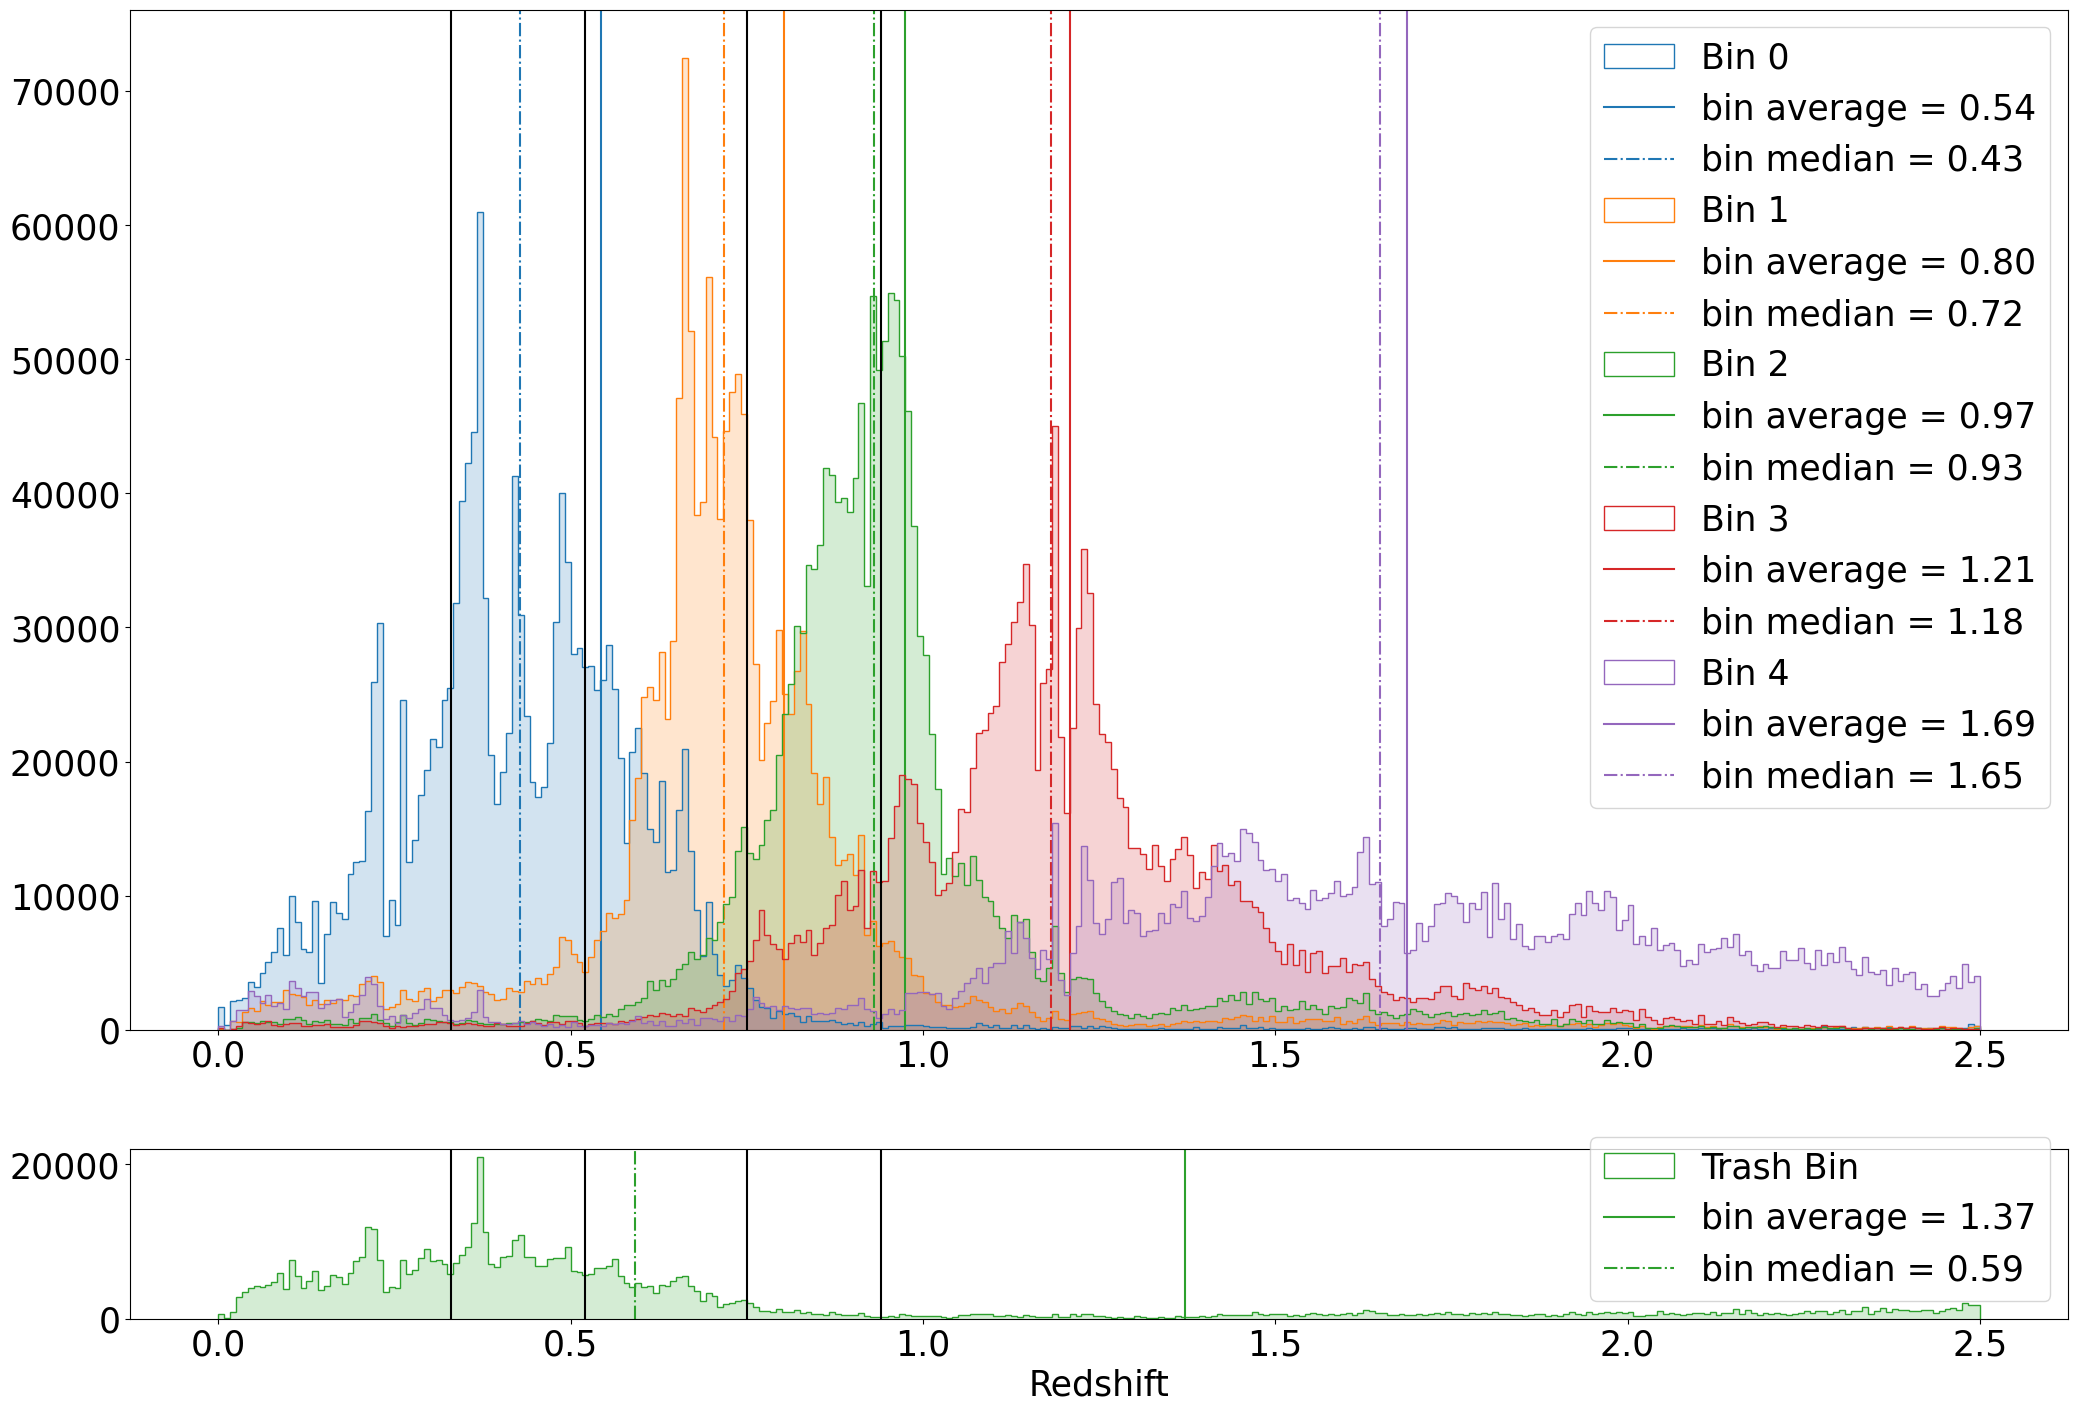

In [24]:
colors = [plt.cm.tab20(i*2) for i in range(5)]

fig, ax = plt.subplots(2, figsize=(25,17), height_ratios=[6,1])
r = (0,2.5)
for i,mask in enumerate(binned_all_data):
    print(len(t[mask]['Z']))
    ax[0].hist(t[mask]['Z'], 300, range=r,histtype='step', color=colors[i], label="Bin %i"%i)
    ax[0].hist(t[mask]['Z'], 300, range=r, alpha=0.2, color=colors[i])
    
    av = np.average(t[mask]['Z']) ; mm = np.median(t[mask]['Z'])
    ax[0].axvline(av, color=colors[i], label='bin average = %.02f'%av)
    ax[0].axvline(mm, linestyle='-.', color=colors[i], label='bin median = %.02f'%mm)
    

ax[1].hist(t_rej['Z'], 300, range=r, alpha=0.2, color=colors[2])
ax[1].hist(t_rej['Z'], 300, range=r, color=colors[2], histtype='step', label='Trash Bin')
av = np.average(t_rej['Z']) ; mm = np.median(t_rej['Z'])
ax[1].axvline(av, color=colors[2], label='bin average = %.02f'%av)
ax[1].axvline(mm, linestyle='-.', color=colors[2], label='bin median = %.02f'%mm)

y3_means = [0.33, 0.52, 0.75, 0.94]
for a in ax:
    for m in y3_means:
        a.axvline(m, color='black')

ax[0].legend(fontsize=25)
ax[1].legend(fontsize=25)
ax[0].tick_params(axis='both', which='major', labelsize=25)
ax[1].tick_params(axis='both', which='major', labelsize=25)

ax[1].set_xlabel('Redshift', fontsize=25)
plt.show()

# Bin Statistics

In [25]:
def get_overlap(binned_all_data):
    nbins = len(binned_all_data)
    nz_all = np.array([np.histogram(t[mask]['Z'], 300, range=r, density=True)[0] for mask in binned_all_data])
    nz_all_overlap = np.einsum('mz,nz->mn', nz_all, nz_all)
    nz_all_overlap_var = np.einsum('m,n->mn', np.sqrt(np.diag(nz_all_overlap)), np.sqrt(np.diag(nz_all_overlap)))
    nz_all_overlap /= nz_all_overlap_var
            
    return nz_all_overlap    

/var/folders/nt/7hp8jjq563b09vy01vqx17dh0000gn/T/ipykernel_31339/3115970084.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap1 = mpl.cm.get_cmap('tab20c')
/var/folders/nt/7hp8jjq563b09vy01vqx17dh0000gn/T/ipykernel_31339/3115970084.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = mpl.cm.get_cmap('tab20c')


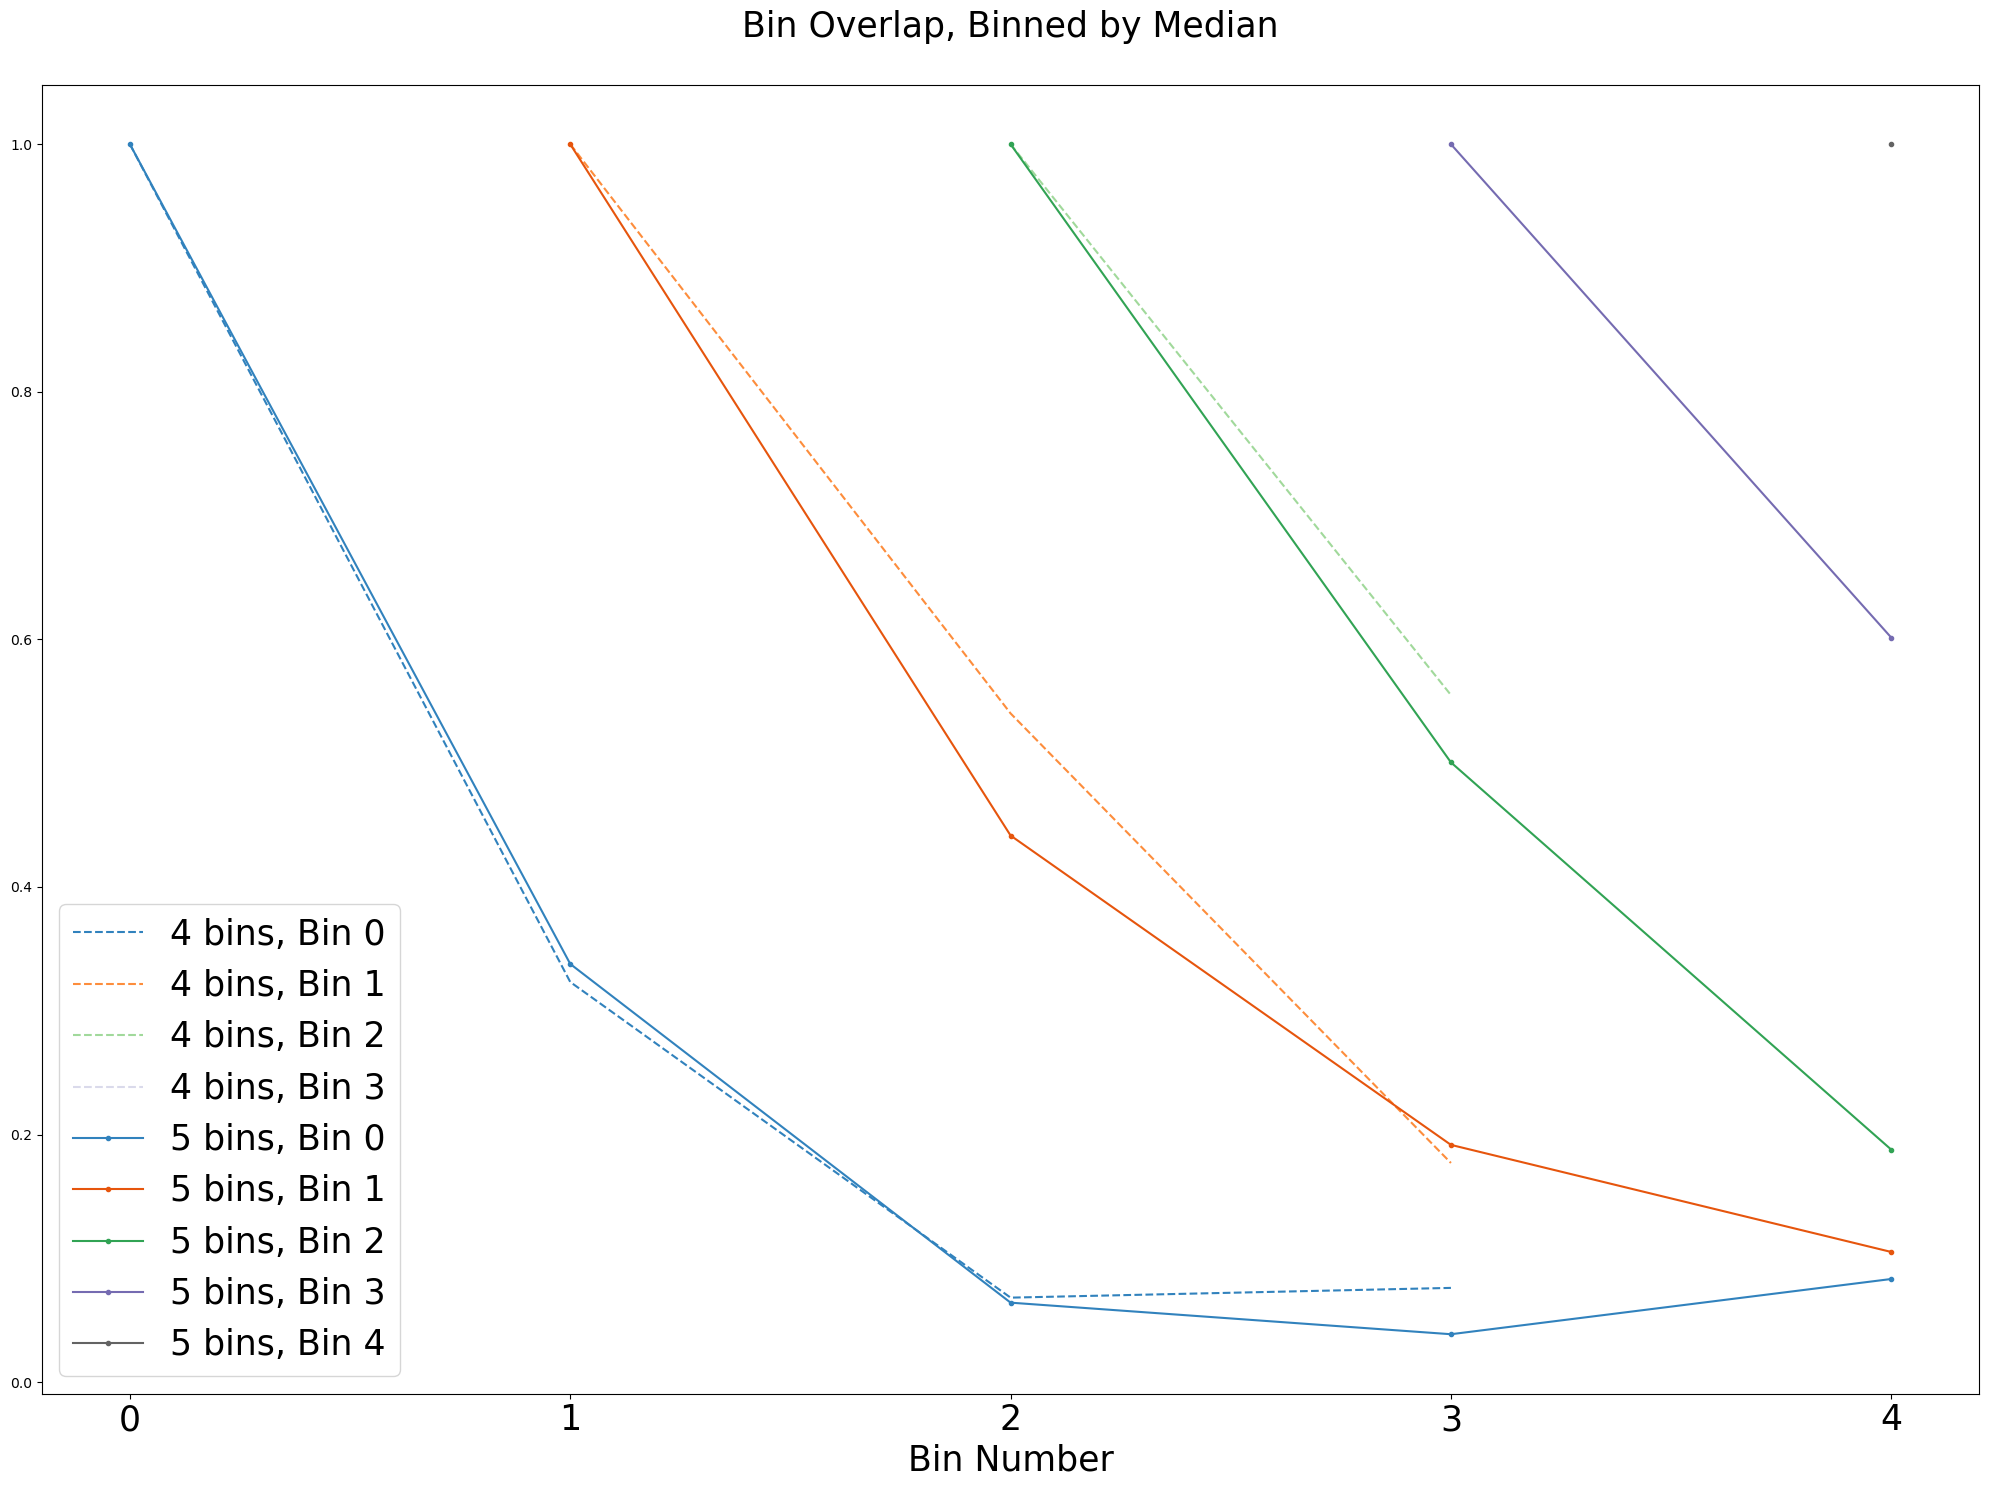

In [26]:
overlaps = {key: get_overlap(masks[key]) for key in masks}

cmap1 = mpl.cm.get_cmap('tab20c')
cmap2 = mpl.cm.get_cmap('tab20c')

for i in range(4):
    plt.plot(range(i, 4), [overlaps['4'][i,j] for j in range(i,4)], '--', 
             label='4 bins, Bin %i'%i, color=cmap1(i/4))
for i in range(5):
    plt.plot(range(i, 5), [overlaps['5'][i,j] for j in range(i,5)], '.-', 
             label='5 bins, Bin %i'%i, color=cmap2(i/5))

plt.xticks(range(nbins), fontsize=25)
plt.xlabel('Bin Number', fontsize=25)
plt.legend(fontsize=25)
plt.title('Bin Overlap, Binned by Median\n', fontsize=25)
plt.gcf().set_size_inches(25,17)
plt.show()

In [27]:
print(np.sum(overlaps['4']), np.sum(overlaps['5']))

7.479490288475628 10.10394897164052


In [29]:
t.write('../outputs/binned_data/accepted_full.fits', overwrite=True)